In [74]:
import os
import tensorflow as tf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Layer, Dense, LayerNormalization, Dropout,Flatten
from keras.models import Model,Sequential
from keras import Input
import visualkeras
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import RootMeanSquaredError
from keras.callbacks import TensorBoard


gpus = tf.config.list_physical_devices('GPU')
if gpus:
	try:
		for gpu in gpus:
			tf.config.experimental.set_memory_growth(gpu,True)
		logical_gpus = tf.config.list_logical_devices('GPU')
		print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} logical GPUs')
	except RuntimeError as e:
		print(f"error setting up gpus: {e}")
else:
	print('no gpus')
class MultiHeadSelfAttention(Layer):
	def __init__(self,embed_dim,num_heads = 8):
		super(MultiHeadSelfAttention,self).__init__()
		self.embed_dim = embed_dim
		self.num_heads = num_heads
		self.projection_dim = embed_dim//num_heads
		self.query_dense = Dense(embed_dim)
		self.key_dense= Dense(embed_dim)
		self.value_dense= Dense(embed_dim)
		self.combine_heads = Dense(embed_dim)
	def attention(self,query,key,value):
		score = tf.matmul(query,key,transpose_b = True)
		dim_key = tf.cast(tf.shape(key)[-1],tf.float32)
		scaled_score = score/tf.math.sqrt(dim_key)
		weights = tf.nn.softmax(scaled_score,axis=-1)
		output = tf.matmul(weights,value)
		return output,weights
	def split_heads(self,x,batch_size):
		x = tf.reshape(x,(batch_size,-1,self.num_heads,self.projection_dim))
		return tf.transpose(x,perm=[0,2,1,3])
	def call(self,inputs):
		batch_size = tf.shape(inputs)[0]
		query = self.query_dense(inputs)
		key = self.key_dense(inputs)
		value = self.value_dense(inputs)
		query = self.split_heads(query,batch_size)
		key = self.split_heads(key,batch_size)
		value = self.split_heads(value,batch_size)
		attention_output,_=self.attention(query,key,value)
		attention_output = tf.transpose(attention_output,perm=[0,2,1,3])
		concat_attention = tf.reshape(attention_output,(batch_size,-1,self.embed_dim))
		return self.combine_heads(concat_attention)
class TransformBlock(Layer):
	def __init__(self,embed_dim,num_heads,ff_dim,rate=0.1):
		super(TransformBlock,self).__init__()
		self.att = MultiHeadSelfAttention(embed_dim,num_heads)
		self.ffn = Sequential([Dense(ff_dim,activation='relu'),Dense(embed_dim),])
		self.layernorm1 = LayerNormalization(epsilon = 1e-6)
		self.layernorm2 = LayerNormalization(epsilon=1e-6)
		self.dropout1 = Dropout(rate)
		self.dropout2 = Dropout(rate)
	def call(self,inputs,training=False):
		attn_output = self.att(inputs)
		attn_output = self.dropout1(attn_output,training=training)
		out1 = self.layernorm1(inputs+attn_output)
		ffn_output = self.ffn(out1)
		return self.layernorm2(out1+ffn_output)
class TransformerEncoder(Layer):
	def __init__(self,num_layers,embed_dim,num_heads,ff_dim,rate=0.1):
		super(TransformerEncoder,self).__init__()
		self.enc_layers = [TransformBlock(embed_dim,num_heads,ff_dim) for _ in range(num_layers)]
		self.dropout = Dropout(rate)
	def call(self,inputs,training=False):
		x = inputs
		x = self.dropout(x,training=training)
		for layer in self.enc_layers:
			x = layer(x,training=training)
		return x
def create_dataset(data,time_step=1):
	X,Y = [],[]
	for i in range(len(data)-time_step-1):
		X.append(data[i:(i+time_step)])
		Y.append(data[(i+time_step),2])
	return np.array(X),np.array(Y)
def build_model(time_step,embed_dim=128,num_heads=8,ff_dim = 512,num_layers=4,dropout_rate=0.1):
	inputs = Input(shape=(time_step,3))
	x = Dense(embed_dim)(inputs)
	encoder = TransformerEncoder(num_layers,embed_dim,num_heads,ff_dim,rate=dropout_rate)
	x = encoder(x)
	x = Flatten()(x)
	x = Dropout(dropout_rate)(x)
	outputs = Dense(1)(x)
	return Model(inputs,outputs)
	
def main():
	np.random.seed(42)
    df_read = pd.read_csv("sim_keff_data.csv")

    # Create a new DataFrame from the first 3000 rows
    df = pd.DataFrame()
    df['Time'] = df_read.iloc[:3000]
    df['keff'] = df_read.iloc[:3000]
    df['cr_pos'] = df_read.iloc[:3000]

    #print(df.head())
	
	print(df.head())
	scaler = MinMaxScaler(feature_range=(0,1))
	scaler2 = MinMaxScaler(feature_range=(0,1))
	scaled_data = scaler.fit_transform(df[['Time','keff','cr_pos']].values)
	scaled_data2 = scaler2.fit_transform(df[['cr_pos']].values)
	time_step = 100
	X,Y = create_dataset(scaled_data,time_step)
	model = build_model(time_step,embed_dim=128,num_heads=8,ff_dim=512,num_layers=4,dropout_rate = 0.1)
	model.compile(optimizer='Adam',loss='mse',metrics=['mae',RootMeanSquaredError(name='rmse')])
	model.summary()
	logdir = os.path.join("logs",datetime.now().strftime("%Y%m%d-%H%M%S"))
	os.makedirs(logdir,exist_ok=True)
	arch_path = os.path.join(logdir,'model_visualkeras.png')
	visualkeras.layered_view(model,to_file=arch_path,legend=True,draw_volume=False,scale_xy=1.5,scale_z=1,spacing=20)
	with tf.summary.create_file_writer(logdir).as_default():
		img = tf.io.read_file(arch_path)
		img = tf.image.decode_png(img,channels=4)
		tf.summary.image("Model_visualization",tf.expand_dims(img,0),step=0)
	tensorboard_cb = TensorBoard(log_dir = logdir,histogram_freq = 1,write_graph=True,write_images=True,update_freq='epoch',profile_batch=1)
	print(f"Tensorboard logs in : {os.path.abspath(logdir)}")
	print(f"Run: tensorboard--logdir{logdir}")
	history = model.fit(X,Y,epochs=20,batch_size = 32,validation_split=0.1,callbacks = [tensorboard_cb])
    df_test = pd.DataFrame()
	df_test['Time'] = df_read.iloc[3000:4000]
	df_test['keff'] = df_read.iloc[3000:4000]
	df_test['cr_pos'] = df_read.iloc[3000:4000]
    scaler_dummy = MinMaxScaler(feature_range=(0,1))
    scaler2_dummy = MinMaxScaler(feature_range=(0,1))
    scaled_data_dummy = scaler_dummy.fit_transform(df_test[['Time','keff','cr_pos']].values)
    #scaled_data_dummy_cr = scaler2_dummy.fit_transform(df_dummy[['cr_pos_dummy']].values)
    x,y = create_dataset(scaled_data_dummy,time_step=27)
	#loss = model.evaluate(X,Y)
	print(X.shape)
	#print("Test loss: ",loss)
	predictions = model.predict(x)
	#print(predictions.shape)
	prediction = predictions.flatten()
	predictions = scaler2.inverse_transform(predictions)
	plt.figure(figsize=(10,6))
	#K=X[:,98,1]
	plt.plot(df['cr_pos'][27:54],label='True data')
	plt.plot(predictions[0:27],label = 'Predictions')
	plt.title('Transformer Time Series Forecasting')
	plt.xlabel('Time')
	plt.ylabel('synthetic data')
	plt.legend()
	plot_path=os.path.join(logdir,'prediction_plot.png')
	plt.savefig(plot_path,dpi=300,bbox_inches='tight')
	print(f"Plot saved to: {plot_path}")
	
if __name__=='__main__':
	main()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 103)

In [22]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data,time_step=1):
	X,Y = [],[]
	for i in range(len(data)-time_step-1):
		X.append(data[i:(i+time_step)])
		Y.append(data[(i+time_step),2])
noise_dummy = np.random.normal(0,1,200)
dummy_data_time = 365*np.sin(np.linspace(0,365,200)) +noise_dummy
dummy_data_keff = 2*np.cos(np.linspace(0,2,200))+noise_dummy
dummy_data_cr = 38*np.cos(100*np.sin(np.linspace(0,38,200)))+noise_dummy
df_dummy = pd.DataFrame()
df_dummy['Time_dummy'] = dummy_data_time
df_dummy['keff_dummy'] = dummy_data_keff
df_dummy['cr_pos_dummy'] = dummy_data_cr
print(df_dummy.head())
scaler_dummy = MinMaxScaler(feature_range=(0,1))
scaler2_dummy = MinMaxScaler(feature_range=(0,1))
scaled_data_dummy = scaler_dummy.fit_transform(df_dummy[['Time_dummy','keff_dummy','cr_pos_dummy']].values)
scaled_data_dummy_cr = scaler2_dummy.fit_transform(df_dummy[['cr_pos_dummy']].values)
x,y = create_dataset(scaled_data_dummy,time_step=199)

   Time_dummy  keff_dummy  cr_pos_dummy
0    1.851054    3.851054     39.851054
1  352.151987    1.738198     37.417236
2 -183.666579    1.827911     34.372186
3 -256.428258    2.442329    -26.111765
4  317.238037    1.993579     37.940978


TypeError: cannot unpack non-iterable NoneType object

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        Y.append(data[(i + time_step), 2])  # assuming column index 2 = cr_pos_dummy
    return np.array(X), np.array(Y)

# Dummy data generation
noise_dummy = np.random.normal(0, 1, 200)
dummy_data_time = 365 * np.sin(np.linspace(0, 365, 200)) + noise_dummy
dummy_data_keff = 2 * np.cos(np.linspace(0, 2, 200)) + noise_dummy
dummy_data_cr = 38 * np.cos(100 * np.sin(np.linspace(0, 38, 200))) + noise_dummy

# DataFrame
df_dummy = pd.DataFrame()
df_dummy['Time_dummy'] = dummy_data_time
df_dummy['keff_dummy'] = dummy_data_keff
df_dummy['cr_pos_dummy'] = dummy_data_cr

# Scaling
scaler_dummy = MinMaxScaler(feature_range=(0, 1))
scaler2_dummy = MinMaxScaler(feature_range=(0, 1))
scaled_data_dummy = scaler_dummy.fit_transform(df_dummy[['Time_dummy', 'keff_dummy', 'cr_pos_dummy']].values)
scaled_data_dummy_cr = scaler2_dummy.fit_transform(df_dummy[['cr_pos_dummy']].values)

# Create dataset
x, y = create_dataset(scaled_data_dummy, time_step=10)


In [41]:
df_dummy['Time_dummy'][100:]

100    342.125721
101     38.359475
102   -361.417313
103    151.340906
104    282.024207
          ...    
195   -166.988296
196    356.356701
197    -18.065151
198   -347.381434
199    197.240935
Name: Time_dummy, Length: 100, dtype: float64

In [29]:
x.shape

(189, 10, 3)

In [30]:
y.shape

(189,)

(1890, 3)


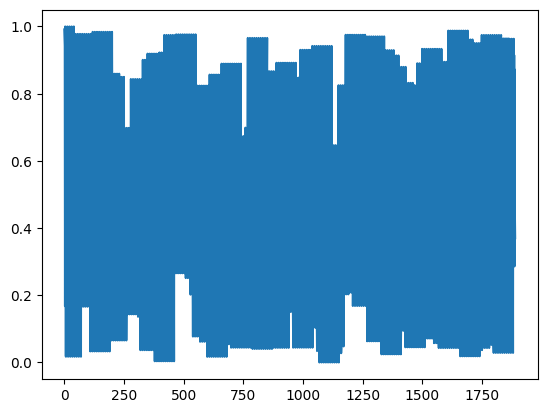

In [36]:
import matplotlib.pyplot as plt
x = x.reshape(-1,x.shape[-1])
print(x.shape)

data_dummy = scaler_dummy.inverse_transform(x)
plt.plot(x[:,2],label='cr_pos vs keff')
plt.show()

In [37]:
import pandas as pd

# Create a sample DataFrame
data = {'Name': ['Alice', 'Bob', 'Charlie'],
        'Age': [25, 30, 22],
        'City': ['New York', 'London', 'Paris']}
df = pd.DataFrame(data)

# Collect the column at index 1 (which is 'Age' in this case)
age_column = df.iloc[:, 1]

print(age_column)

0    25
1    30
2    22
Name: Age, dtype: int64


In [38]:
import pandas as pd

# Create a sample DataFrame
df = pd.DataFrame({'col1': range(100), 'col2': [f'data_{i}' for i in range(100)]})

# Get the first N rows for training
n_rows_for_train = 80
train_df = df.iloc[:n_rows_for_train]

print(train_df.shape) # (80, 2)

(80, 2)


In [57]:
import numpy as np
import pandas as pd

# Generate random data
x = np.random.normal(0, 10, 1000)

# Put it into a DataFrame
df = pd.DataFrame()
df[0] = x  # Correct way to assign a column in pandas
print(df.shape)
# Set time_step
time_step = 27
data=[]
# Loop through to slice the data
for i in range(len(df) - time_step - 1):
    data_p =  df[i:i + time_step]
    data.append(data_p)
# Print length of the last sliced `data`
print(len(data))


(1000, 1)
972


In [78]:
df_read = pd.read_csv("sim_keff_data.csv")
df_test = pd.DataFrame()
df_test['Time'] = df_read['time'].iloc[0:1000]
df_test['keff'] = df_read['keff'].iloc[0:1000]
df_test['cr_pos'] = df_read['rod_position'].iloc[0:1000]

In [80]:
noise = np.random.normal(0,1,1000)

In [81]:
df_test['Time'] = df_read['time'].iloc[0:1000]+noise
df_test['keff'] = df_read['keff'].iloc[0:1000] +noise
df_test['cr_pos'] = df_read['rod_position'].iloc[0:1000]+noise